# Todo


- Implement LGS ✅
- Implement VSGS ✅
- Explore multiple dataset generation approach ✅ (Just scenario 3 left, I am not sure if it is important)
- Show results ✅
- Implement PSD estimation algorithm (currently the true PSD is used) ✅
- Compare the "graph baseline" with traditional kernel methods ~ need some work to find penalty parameter

In [54]:
import numpy as np
import pygsp
import ruptures as rpt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from ruptures.metrics import *
from tqdm.auto import tqdm
from scipy.stats import gamma

SEED = 6326572
np.random.seed(SEED)

In [55]:
def metrics(true_bkps, bkps, log=True):
    p, r = rpt.metrics.precision_recall(true_bkps, bkps)
    hausdorff = rpt.metrics.hausdorff(true_bkps, bkps)
    randindex = rpt.metrics.randindex(true_bkps, bkps)
    hamming = rpt.metrics.hamming(true_bkps, bkps)
    print(f"""
        Hausdorff: {hausdorff:.2f}, 
        Precision: {p:.2f}, 
        Recall: {r:.2f}, 
        Randindex: {randindex:.2f}, 
        Hamming: {hamming:.2f}
    """)
    return p, r, hausdorff, randindex

# Dataset

4 changes points


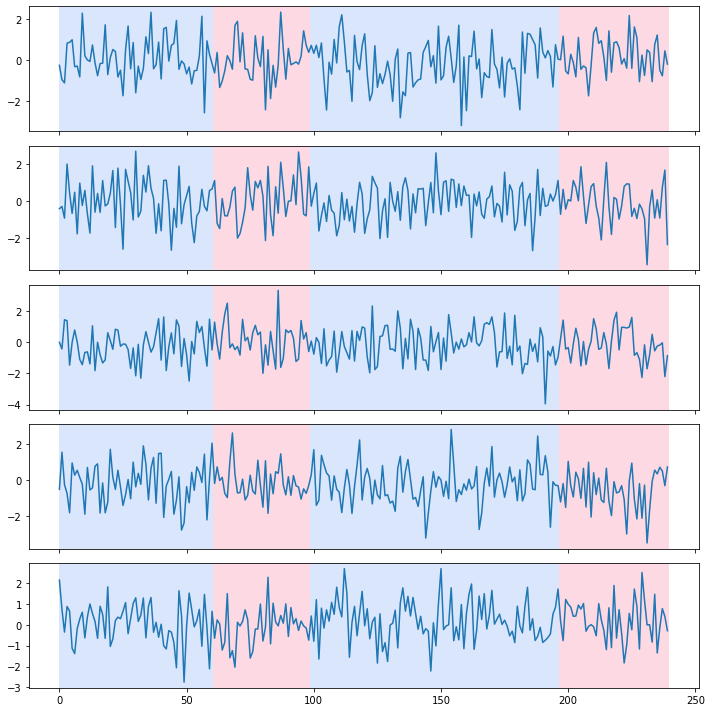

In [56]:
def generate_barabasi_albert(
        n_nodes,
        m_barabasi=4,
        mean_exponential=20,
        random_freq=20
    ):
    # Generate Graph Structure
    G = pygsp.graphs.BarabasiAlbert(N=n_nodes, m0=m_barabasi, m=m_barabasi, seed=SEED)
    G.set_coordinates()
    G.compute_fourier_basis()

    spectral_profile=lambda x: 2*gamma.pdf(x,a=20.,loc=5.)+1.0
    H = pygsp.filters.Filter(G, lambda x: spectral_profile(x))
    PSD = (spectral_profile(G.e))**2

    # Generate Signals
    n_bkps = 4
    bkps = []
    mus = []
    signals = []
    
    acc_bkp = 0
    acc_mean = np.mean(G.U[:,:20], axis=1).reshape(-1, 1)
    # Make a list of changing points after each breakpoints
    changing_nodes = []
    changing_nodes.append(tuple([[]])) # In the first part, no mean are changed
    max_d = np.argmax(G.d)
    max_d_neighbors = np.where(G.W.todense()[max_d] != 0)[1]
    changing_nodes.append(np.concatenate([max_d_neighbors, [max_d]])) # After the first break, node with maximum degree and neighbord change
    changing_nodes.append(np.argpartition(G.d, -5)[-5:]) # After the second break, 5 nodes with highest degree change
    changing_nodes.append(np.random.choice(range(n_nodes), size=random_freq, replace=False)) # After last break, 20 random nodes are changes

    for i in range(n_bkps):
        # Generate segment
        segment_length = int(np.random.exponential(scale=mean_exponential)+30)
        acc_bkp += segment_length
        acc_mean[changing_nodes[i]] = np.random.uniform(-5.0,5.0,size=(len(changing_nodes[i]),1)) # Changing mean of corresponding nodes
        signal = np.random.normal(size=(n_nodes,segment_length))
        signal = H.filter(signal) + G.igft(acc_mean)

        # Record bkp position, mean and signal
        bkps.append(acc_bkp)
        mus.append(np.copy(acc_mean))
        signals.append(signal)

    signal = np.concatenate(signals, 1)
    return G, PSD, bkps, mus, signal

# Params
n_nodes = 500   
G, PSD, true_bkps, mus, signal = generate_barabasi_albert(n_nodes)
print(f'{len(true_bkps)} changes points')
rpt.display(signal[:5].T, true_bkps)
plt.show()

7 changes points


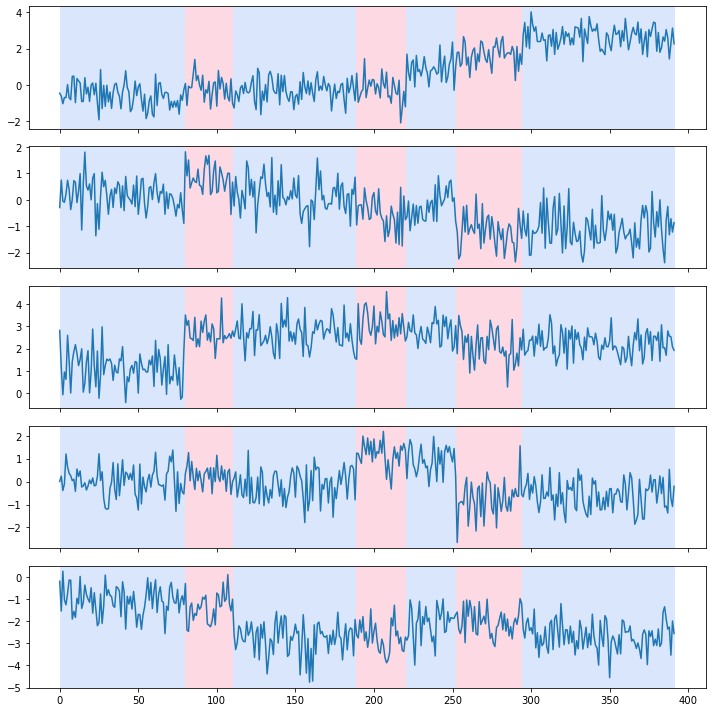

In [57]:
# Params
n_nodes = 500
p = 0.3
mean_exponential = 50
mean_change_points = 5
random_freq = 40

def generate_erdos_renyi(
        n_nodes,
        p,
        mean_exponential=50,
        mean_change_points=5,
        random_freq=20
    ):
    # Generate Graph Structure
    G = pygsp.graphs.ErdosRenyi(N=n_nodes, p=p, seed=SEED)
    G.set_coordinates()
    G.compute_fourier_basis()

    spectral_profile = lambda x: np.sqrt(15)/(np.log(x+10)+1)
    H = pygsp.filters.Filter(G, lambda x: spectral_profile(x))
    PSD = (spectral_profile(G.e))**2

    # Generate Signals
    n_bkps = np.random.poisson(lam=mean_change_points)
    bkps = []
    mus = []
    signals = []
    
    acc_bkp = 0
    acc_mean = np.zeros((n_nodes,1)) # Au départ la moyenne est la combinaison de vecteurs propres ?
    for bkpt in range(n_bkps):
        # Get new segment mean
        subset_freq = np.random.choice(range(n_nodes), size=random_freq, replace=False)
        acc_mean[subset_freq] = np.random.uniform(-5.0,5.0,size=(random_freq,1))

        # Generate segment
        segment_length = int(np.random.exponential(scale=mean_exponential)+30)
        acc_bkp += segment_length
        signal = np.random.normal(size=(n_nodes,segment_length)) # Ici on devrait avoir uniform et pas normal
        signal = H.filter(signal) + G.igft(acc_mean)
        # Record bkp position, mean and signal
        bkps.append(acc_bkp)
        mus.append(np.copy(acc_mean))
        signals.append(signal)
    signal = np.concatenate(signals, 1)
    return G, PSD, bkps, mus, signal
    
G, PSD, true_bkps, mus, signal = generate_erdos_renyi(n_nodes,p,mean_exponential,mean_change_points,random_freq)
print(f'{len(true_bkps)} changes points')
rpt.display(signal[:5].T, true_bkps)
plt.show()

# PSD Estimation

In [58]:
def gaussian_kernel(x, m, tau, sig_2):
    return np.exp( -np.square(x - m * tau) / sig_2)

def estimate_PSD_cov(signal, G):
    """This functions allows to estimate the PSD of the graphs signals using covariance estimation.

    Args:
        signal: array, shape (n_nodes, T) the stream of graph signals.
        G: pygsp.graphs,  the graph

    Returns:
        PSD : array, shape (n_nodes) : the PSD of the graphs signals 

    """

    cov = np.cov(signal)
    PSD = np.diagonal(np.conj(G.U).T @ cov @ G.U)
    return PSD


def estimate_PSD_perraudin(signal, G, M=100, filtering_method='chebyshev', exact_window_norm=False, interp_degree=15 ):
    """This functions allows to estimate the PSD of the graphs signals using perraudin method.

    Args:
        signal: array, shape (n_nodes, T) the stream of graph signals.
        G: pygsp.graphs,  the graph
        M : int, number of filters to use
        filtering_method : string, method to use for filtering graphs, either "exact" or "chebyshev"
        window_norm : bool, use exact computation of the window norm
        interp_degree: int, polynomial degree for the interpolation 

    Returns:
        PSD : array, shape (n_nodes) : the PSD of the graphs signals 

    """
    np.random.seed(SEED)
    tau = (M+1) * G.lmax / np.square(M)
    sig_2 = tau
    psd = []
    
    if not exact_window_norm:
        noise = np.random.normal(size=(signal.shape[0], 10))

    for m in range(M):
        filter = lambda x : gaussian_kernel(x, m, tau, sig_2)
        G_filter = pygsp.filters.Filter(G, filter)
        
        if exact_window_norm:
            window_norm = np.sum(np.square(filter(G.e))) + 1e-16
        else:
            filterned_noise = G_filter.filter(noise, method=filtering_method)
            window_norm = np.mean(np.sum(np.square(filterned_noise), axis=0))


        filtered_signal = G_filter.filter(signal, method=filtering_method)
        filtered_signal_norm = np.mean(np.sum(np.square(filtered_signal), axis=0))
        
        psd.append(filtered_signal_norm / window_norm)

    xs = tau * np.arange(M)

    coeff=np.polyfit(xs,np.array(psd),deg=interp_degree)
    p = np.poly1d(coeff)

    PSD=p(G.e)
    return PSD
    

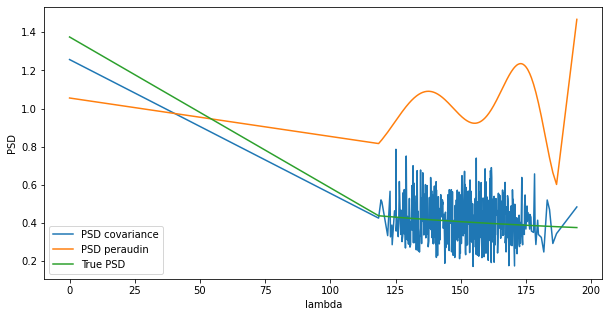

In [59]:
# Compare True PSD and approximation
w = 30
psd_covariance = estimate_PSD_cov(signal[:,:w], G)
psd_perraudin = estimate_PSD_perraudin(signal[:,:w], G)

fig = plt.figure(figsize=(10, 5)) 
plt.plot(G.e, psd_covariance, label="PSD covariance")
plt.plot(G.e, psd_perraudin, label="PSD peraudin")
plt.plot(G.e, PSD, label="True PSD")
plt.xlabel("lambda")
plt.ylabel("PSD")
plt.legend()
plt.show()

# LGS

In [60]:
class CostFunctionLGS(rpt.base.BaseCost):
    model = "lgs"
    min_size = 2
    def __init__(self, psd, lbd):
        self.lbd = lbd
        self.signal = None
        self.psd = psd
        
    def fit(self, signal):
        self.signal = signal
        return self
        
    def error(self, start, end):
        y_tilda_bar = np.mean(self.signal[start:end],axis=0)
        temp = np.abs(y_tilda_bar) - 0.5*self.lbd*self.psd
        mu_tilda_bar = np.sign(y_tilda_bar) * np.maximum(temp,0)
        
        sub_sig = np.square(self.signal[start:end] - mu_tilda_bar) / self.psd
        sub_sig += self.lbd * np.abs(mu_tilda_bar)
        
        return np.sum(sub_sig)

def fullCostLGS(cost_fct, bkps, d, T, c1, c2):
    temp = sum([cost_fct.error(bkps[k-1],bkps[k]) for k in range(1,len(bkps))])
    temp += d * (c1 + c2 * np.log(T/d))
    return temp
    
def LGS(G, signal, PSD, d_max=75, lbd=1.):
    GFT = signal @ G.U
    PSD = PSD
    cost = CostFunctionLGS(PSD, lbd).fit(GFT)
    algo = rpt.Dynp(custom_cost=cost).fit(GFT)
    best_cost = float('inf')
    best_bkps = None
    for d in tqdm(range(1,d_max+1)):
        bkps = algo.predict(n_bkps=d)
        curr_cost = fullCostLGS(cost, [0, *bkps], d, len(GFT), 500., 100.)
        if curr_cost < best_cost:
            best_cost = curr_cost
            best_bkps = bkps
    return best_bkps

100%|██████████| 65/65 [00:06<00:00,  9.62it/s]


7 changes points

        Hausdorff: 2.00, 
        Precision: 1.00, 
        Recall: 1.00, 
        Randindex: 0.99, 
        Hamming: 0.01
    


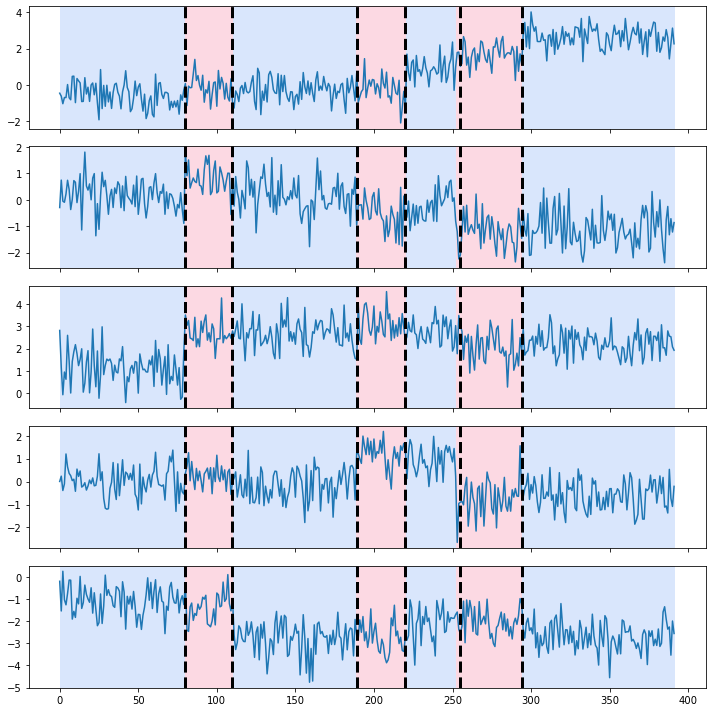

In [61]:
# Results using True PSD
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = LGS(G, signal.T, PSD, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 65/65 [00:02<00:00, 22.66it/s]


7 changes points

        Hausdorff: 2.00, 
        Precision: 1.00, 
        Recall: 1.00, 
        Randindex: 0.99, 
        Hamming: 0.01
    


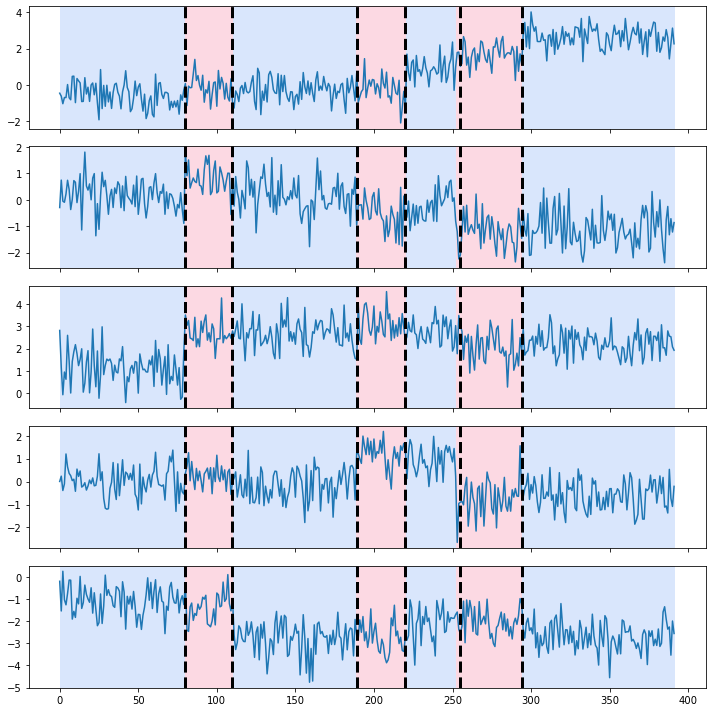

In [62]:
# Results using PSD estimation through covariance estimation
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = LGS(G, signal.T, psd_covariance, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 65/65 [00:03<00:00, 20.61it/s]


2 changes points

        Hausdorff: 180.00, 
        Precision: 1.00, 
        Recall: 0.17, 
        Randindex: 0.61, 
        Hamming: 0.39
    


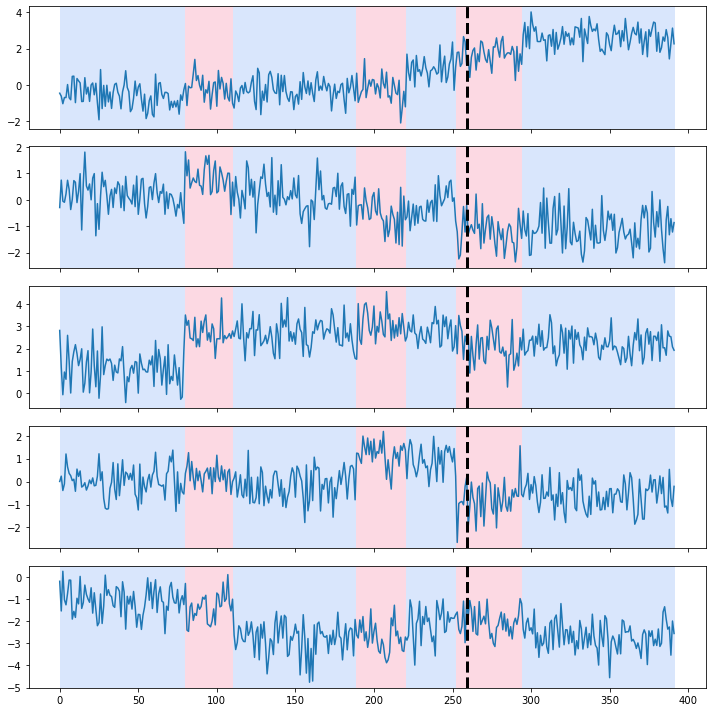

In [63]:
# Results using PSD estimation with perraudin methods
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = LGS(G, signal.T, psd_perraudin, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

# VSGS

In [64]:
def lassoVSGS(signal, PSD, lbd):
    """
    Solves the lasso problem from Algorithm2 VSGS
    Solution is computed via a closed form
    """
    emp_mean = np.mean(signal, axis=0)
    temp = np.abs(emp_mean) - 0.5*lbd*PSD
    mu = np.sign(emp_mean) * np.maximum(temp,0)
    return mu

class CostFunctionVSGS(rpt.base.BaseCost):
    model = "vsgs"
    min_size = 2
    def __init__(self, psd, filter_mask):
        self.signal = None
        self.filter_mask = filter_mask
        self.psd = psd
        
    def fit(self, signal):
        self.signal = signal
        return self
        
    def error(self, start, end):
        emp_mean = np.mean(self.signal[start:end],axis=0)
        emp_mean *= self.filter_mask
        temp = np.square(self.signal[start:end] - emp_mean) / self.psd
        return np.sum(temp)

def fullCost(cost_fct, bkps):
    cost = sum([cost_fct.error(bkps[k-1],bkps[k]) for k in range(1,len(bkps))])
    return cost
    
def slopeHeuristic(parameters, T):
    X = np.zeros((len(parameters), 3))
    X[:,0] = parameters[:,2]
    X[:,1] = parameters[:,1]
    X[:,2] = parameters[:,1] * np.log(T / parameters[:,1])
    X /= T
    y = parameters[:,3] / T
    constants = -1 * LinearRegression().fit(X, y).coef_
    return constants.tolist()

def VSGS(G, signal, PSD, lambda_set, d_max=75):
    GFT = signal @ G.U
    PSD = PSD
    T = len(signal)
    parameters_list = np.zeros((len(lambda_set)*d_max, 4)) # Array storing lbd, Dm, d, cost for each iteration
    bkps_list = [] # List storing bkps for each set of parameters
    count = 0
    for lbd in tqdm(lambda_set):
        mu = lassoVSGS(GFT, PSD, lbd)
        filter_freq = np.nonzero(np.abs(mu))[0] # Frequencies kept by Lasso
        filter_mask = (np.abs(mu) > 0) * 1. # Mask = 1 when a frequency is kept
        D_m = int(len(filter_freq)) # Number of kept frequencies
        cost = CostFunctionVSGS(PSD, filter_mask).fit(GFT)
        algo = rpt.Dynp(custom_cost=cost).fit(GFT)
        for d in range(1, d_max+1):
            bkps = algo.predict(n_bkps=d)
            curr_cost = fullCost(cost, [0, *bkps])
            bkps_list.append(bkps)
            parameters_list[count] = [lbd, d, D_m, curr_cost]
            count += 1
    K1, K2, K3 = slopeHeuristic(parameters_list, T)
    # Compute full costs with penalty + constants
    final_costs = parameters_list[:,3]
    final_costs += K1 * parameters_list[:,2]
    final_costs += K2 * parameters_list[:,1]
    final_costs += K3 * parameters_list[:,1] * np.log(T / parameters_list[:,1])

    plt.plot(final_costs)
    best_params_idx = np.argmin(final_costs)
    return bkps_list[best_params_idx]

100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


7 changes points

        Hausdorff: 2.00, 
        Precision: 1.00, 
        Recall: 1.00, 
        Randindex: 0.99, 
        Hamming: 0.01
    


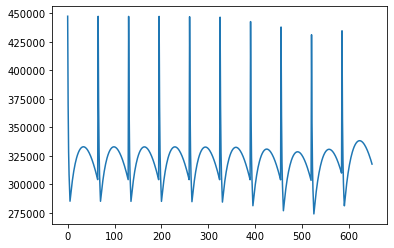

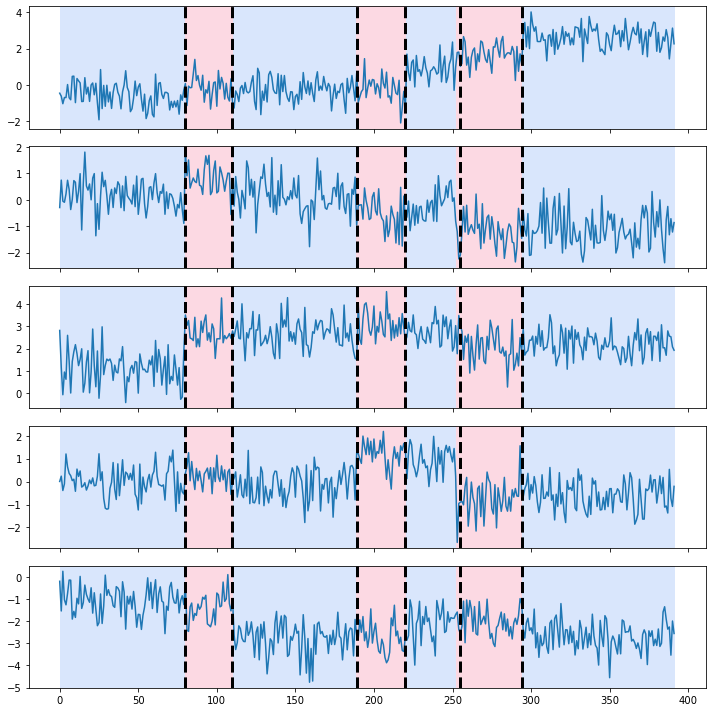

In [65]:
# Results using True PSD
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = VSGS(G, signal.T, PSD, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 10/10 [00:29<00:00,  2.90s/it]


7 changes points

        Hausdorff: 2.00, 
        Precision: 1.00, 
        Recall: 1.00, 
        Randindex: 0.99, 
        Hamming: 0.01
    


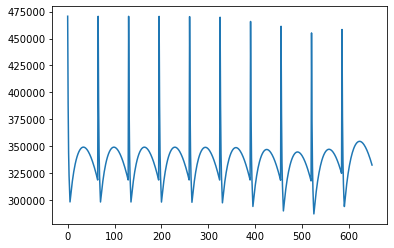

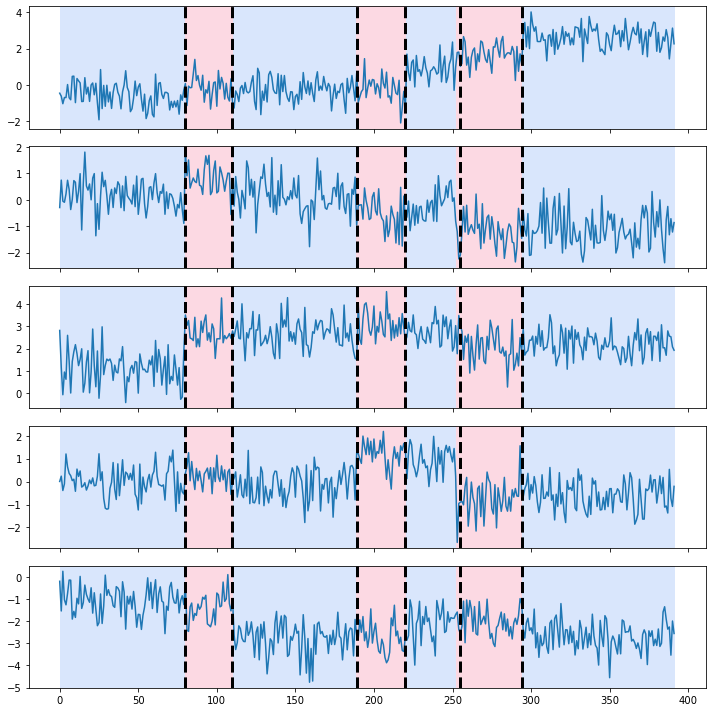

In [67]:
# Results using PSD estimation through covariance estimation
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = VSGS(G, signal.T, psd_covariance, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


3 changes points

        Hausdorff: 39.00, 
        Precision: 1.00, 
        Recall: 0.67, 
        Randindex: 0.86, 
        Hamming: 0.14
    


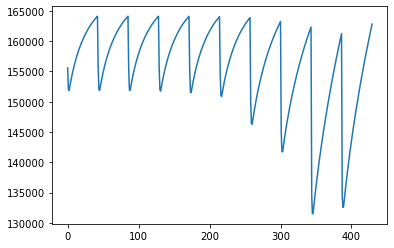

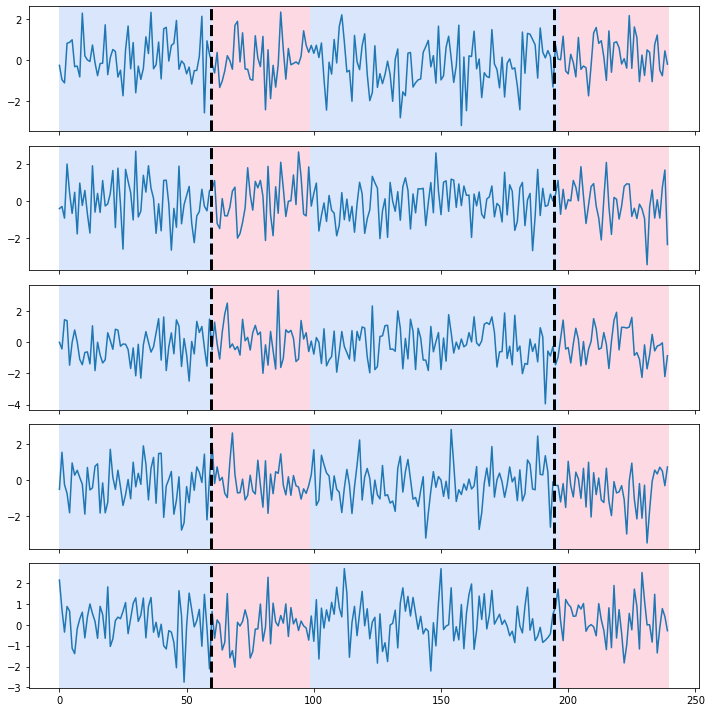

In [13]:
# Results using PSD estimation with perraudin methods
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = signal.shape[1]
d_max = int(T/np.log(T))
bkps = VSGS(G, signal.T, psd_perraudin, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
metrics(true_bkps, bkps)
rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

# Kernel methods

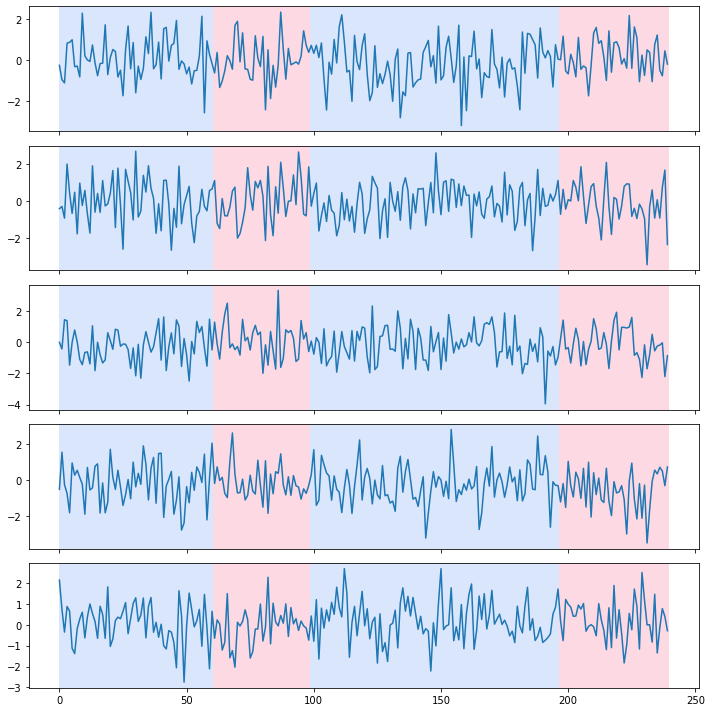

In [14]:
kernel_method_linear = rpt.KernelCPD(kernel="linear", min_size=2).fit(signal)

penalty_value = 1350  # beta handcrafted
bkps = kernel_method_linear.predict(pen=penalty_value)

rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

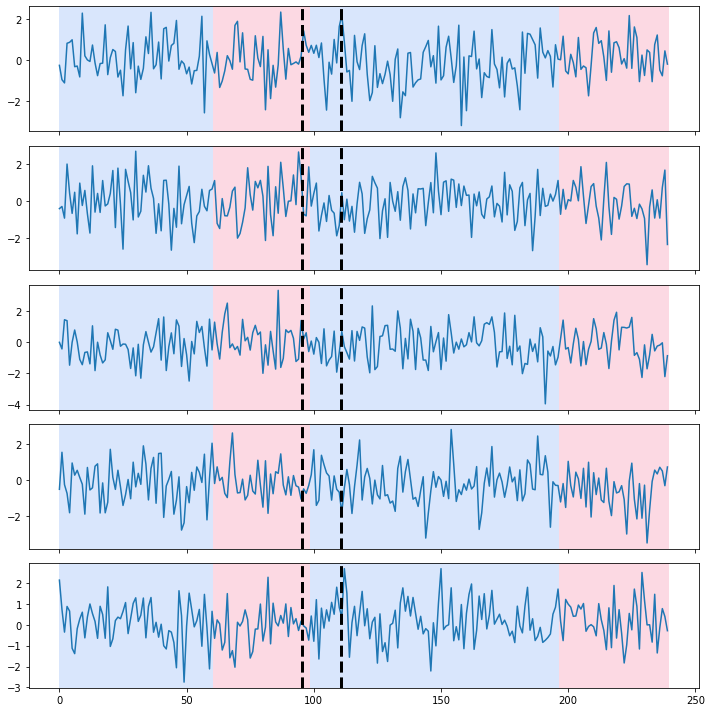

In [15]:
kernel_method_rbf = rpt.KernelCPD(kernel="rbf", min_size=2).fit(signal)

penalty_value = 1.1  # beta handcrafted
bkps = kernel_method_rbf.predict(pen=penalty_value)

rpt.display(signal[:5].T, true_bkps, bkps)
plt.show()

# Application to real data

In [1]:
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
import geopandas
import contextily as cx

CRS = "EPSG:4326"

In [71]:
# Load data
data_df, stations_df, description = load_molene_meteo_dataset()

In [117]:
### Preprocessing of temperature dataframe

data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)

# Drop NaN values
temperature_df = temperature_df.dropna(axis=1)

print(f"The stations with missing values are {', '.join(sorted(list((set(data_df['station_name'])  - set(temperature_df.columns))))).title()}") 

temperature_df.head()

The stations with missing values are Arzal, Batz, Beg_Meil, Brest-Guipavas, Brignogan, Camaret, Landivisiau, Lannaero, Lanveoc, Ouessant-Stiff, Plouay-Sa, Ploudalmezeau, Plougonvelin, Quimper, Riec Sur Belon, Sizun, St Nazaire-Montoir, Vannes-Meucon


station_name,AURAY,BELLE ILE-LE TALUT,BIGNAN,DINARD,GUERANDE,GUISCRIFF SA,ILE DE GROIX,ILE-DE-BREHAT,KERPERT,LORIENT-LANN BIHOUE,...,SAINT-CAST-LE-G,SAINT-JOACHIM_SAE,SARZEAU SA,SIBIRIL S A,SPEZET,ST BRIEUC,ST-SEGAL S A,THEIX,TREGUNC,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,10.3,11.3,7.1,6.8,10.4,8.3,9.0,7.0,5.9,9.0,...,6.1,9.3,9.8,7.4,8.3,7.5,9.0,9.3,10.8,9.7
2014-01-01 01:00:00,10.4,10.3,7.6,6.5,10.6,7.8,10.0,7.0,5.9,10.0,...,6.3,9.3,9.9,8.2,8.6,7.0,9.5,9.1,10.9,9.9
2014-01-01 02:00:00,10.0,11.2,7.7,6.5,10.2,8.4,9.5,7.8,6.4,8.9,...,6.4,9.5,9.2,8.5,8.6,7.5,9.4,9.4,10.6,9.6
2014-01-01 03:00:00,10.4,11.4,7.9,7.1,10.6,8.4,10.4,8.3,6.7,10.1,...,7.0,9.0,10.1,8.5,8.9,7.2,9.9,8.9,10.8,9.8
2014-01-01 04:00:00,10.8,11.4,8.8,7.6,10.6,8.9,10.8,8.9,6.9,10.4,...,7.7,9.9,10.5,9.1,9.4,7.6,10.0,9.6,11.0,10.2


In [118]:
### Preprocessing of stations dataframe

stations_df_filtered = stations_df[stations_df['Nom'].isin(list(temperature_df.columns))]

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df_filtered,
    geometry=geopandas.points_from_xy(
        stations_df_filtered.Longitude, stations_df_filtered.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)
5,22168001,PLOUMANAC'H,48.825833,-3.473167,173516,2441036,55,POINT (-3.47317 48.82583)


In [119]:
from scipy.spatial.distance import pdist, squareform
from math import asin, cos, radians, sin, sqrt
from pygsp import graphs

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [120]:
# Compute geodedic distances between all stations 
stations_np = stations_df_filtered[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance) # Distances computed in km

# Compute similarity using gaussian smoothing and median heuristic for bandwith parameter
bandwidth = np.median(dist_mat_condensed) # median heuristic
exp_similarity = np.exp( -(dist_mat_condensed ** 2) / np.square(bandwidth))

# Performs dichotomy to find the minimum threshold that keeps the graph connected with an average degree of at least 3
low = 0
high = 1
threshold = 1
eps = 1e-5
while np.abs(high - low) > eps:
    threshold = (high + low) / 2
    adjacency_matrix_gaussian = squareform(np.where(exp_similarity > threshold, exp_similarity, 0.0))
    G = graphs.Graph(adjacency_matrix_gaussian)
    is_connected = G.is_connected(recompute=True)
    if is_connected:
        low = threshold
    else:
        high = threshold

adjacency_matrix_gaussian = squareform(np.where(exp_similarity > low, exp_similarity, 0.0))
G = graphs.Graph(adjacency_matrix_gaussian)
is_connected = G.is_connected(recompute=True)

print(f"The minimum threshold so that the graph is connected is {low:.4f}.")
print(f"The average degree of the graph is {np.mean(G.d):.2f}.")
print(f"The average weighted degree of the graph is {np.mean(np.sum(adjacency_matrix_gaussian, axis=0)):.2f}")

The minimum threshold so that the graph is connected is 0.8324.
The average degree of the graph is 4.00.
The average weighted degree of the graph is 3.62


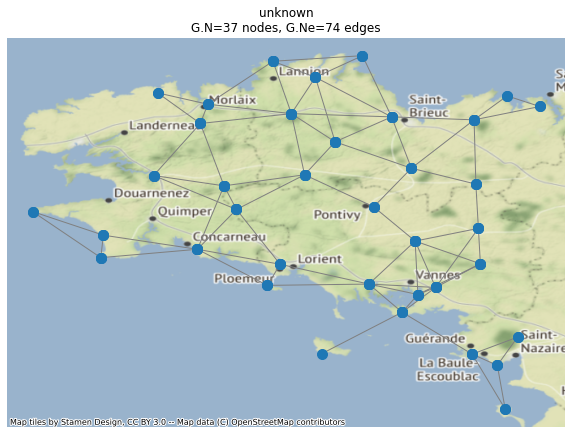

In [121]:
# Plot the graph
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

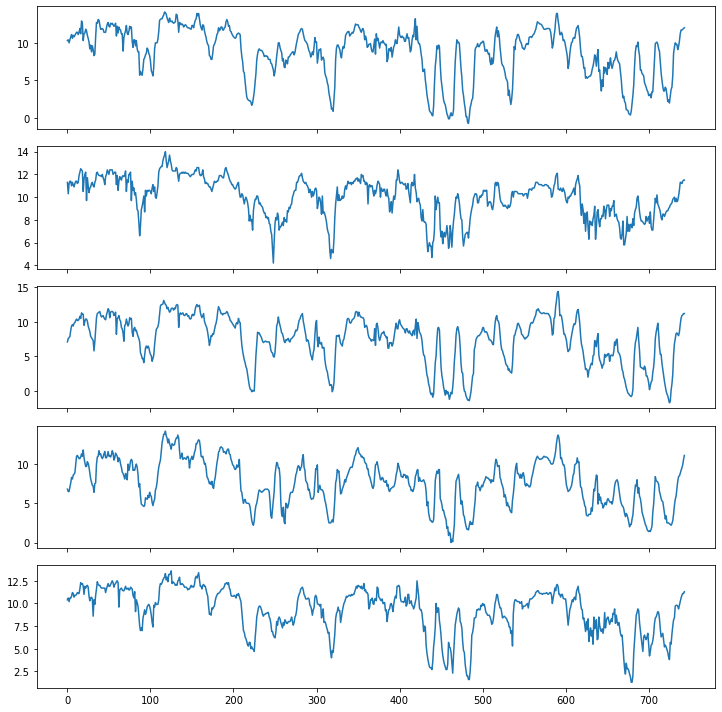

In [122]:
temperature_df_np = np.array(temperature_df)
rpt.display(temperature_df_np[:,:5], [])
plt.show()

2022-03-28 17:38:50,432:[WARNING](pygsp.graphs.graph._check_fourier_properties): The Fourier basis G.U is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


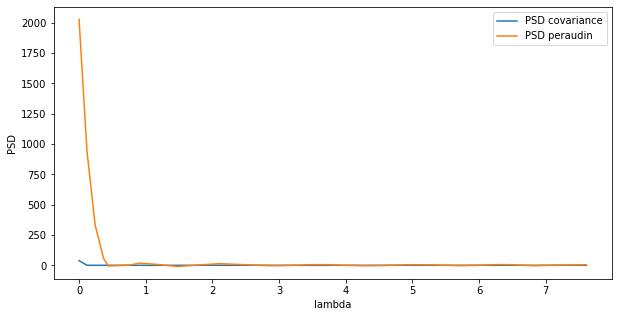

In [123]:
# Compute PSD
w = 80
psd_covariance_temp = estimate_PSD_cov(temperature_df_np[:w].T, G)
psd_perraudin_temp = estimate_PSD_perraudin(temperature_df_np[:w].T, G)

fig = plt.figure(figsize=(10, 5)) 
plt.plot(G.e, psd_covariance_temp, label="PSD covariance")
plt.plot(G.e, psd_perraudin_temp, label="PSD peraudin")
plt.xlabel("lambda")
plt.ylabel("PSD")
plt.legend()
plt.show()

## LGS

100%|██████████| 112/112 [00:09<00:00, 11.70it/s]


2 changes points


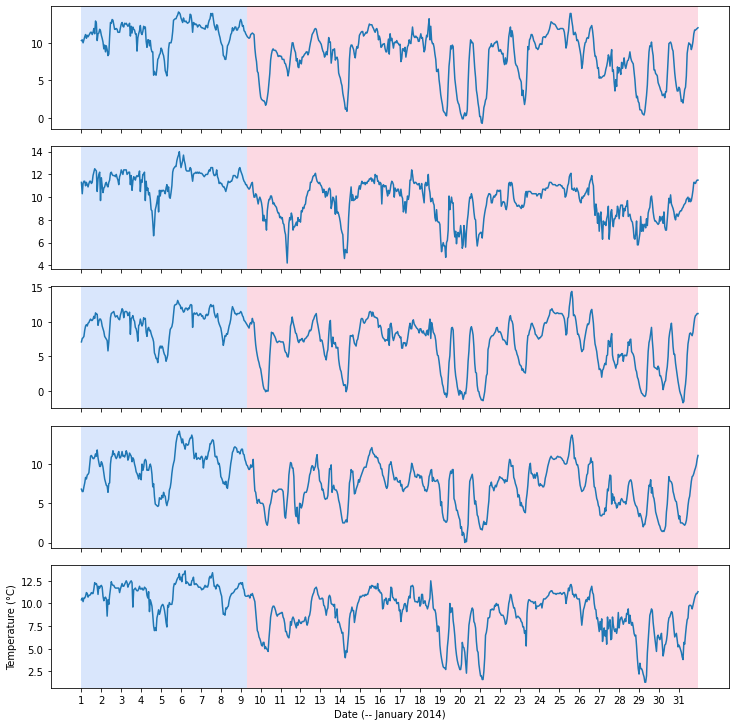

In [152]:
# Results Covariance PSD
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = LGS(G, temperature_df_np, psd_covariance_temp, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')

rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()

100%|██████████| 112/112 [00:15<00:00,  7.23it/s]


2 changes points


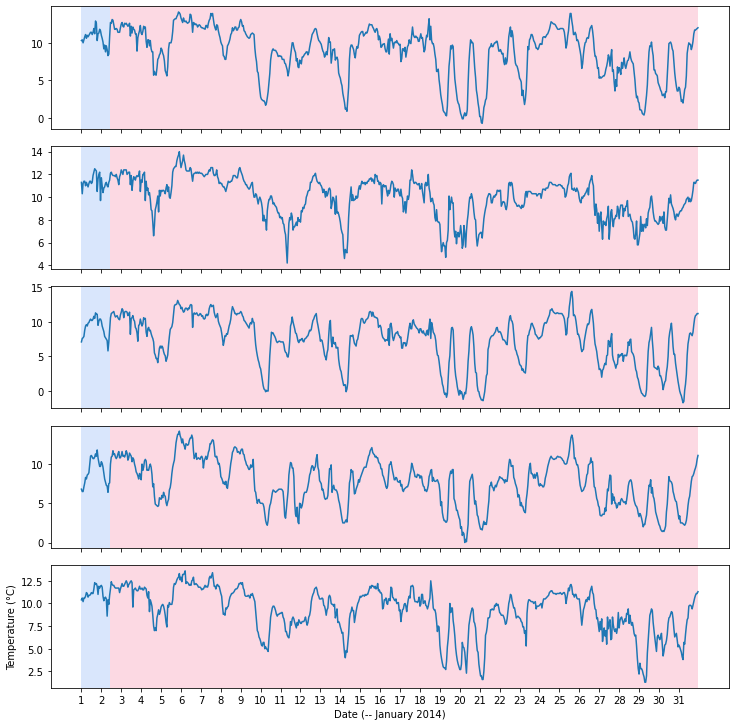

In [153]:
# Results Covariance PSD
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = LGS(G, temperature_df_np, psd_perraudin_temp, d_max=d_max, lbd=10.)
print(f'{len(bkps)} changes points')

rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()

## VSGS

100%|██████████| 10/10 [02:15<00:00, 13.52s/it]


17 changes points


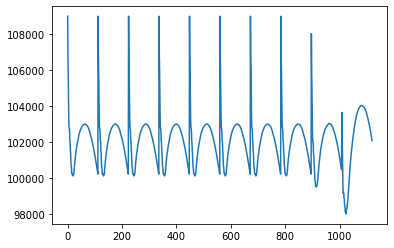

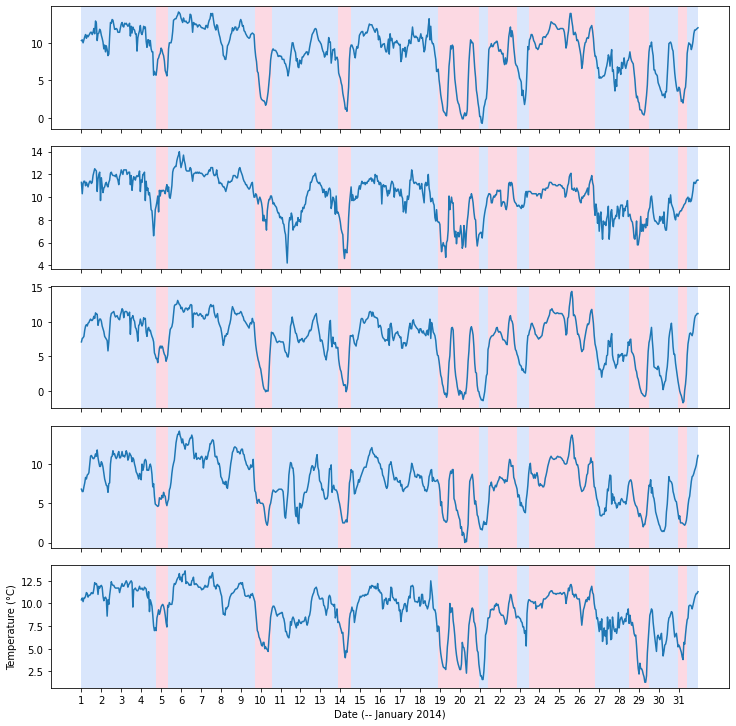

In [149]:
# Results using Covariance PSD
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = VSGS(G, temperature_df_np, psd_covariance_temp, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()

100%|██████████| 10/10 [00:58<00:00,  5.86s/it]


11 changes points


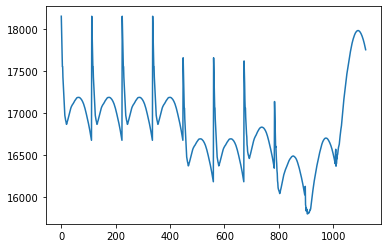

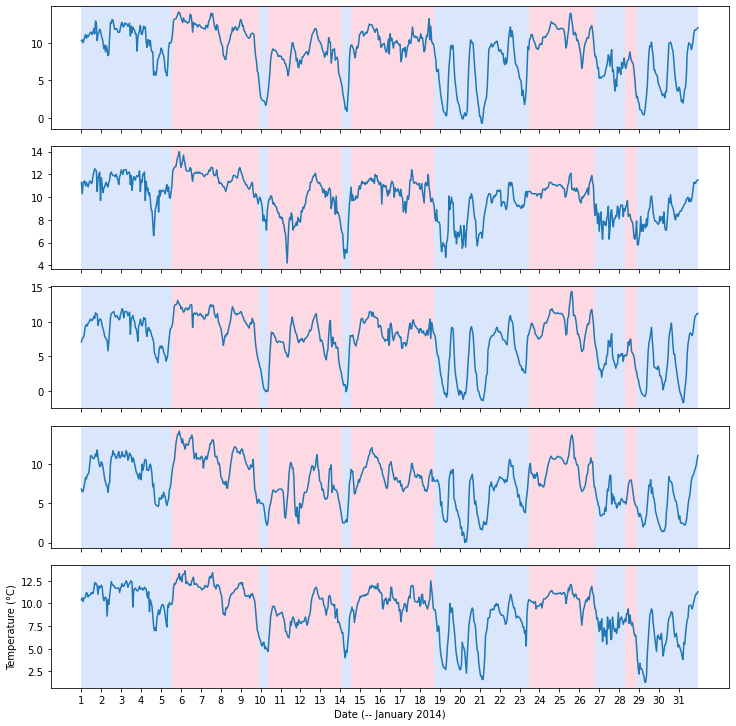

In [150]:
# Results using Peraudin PSD
lambda_set = [0,0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.]
T = temperature_df_np.shape[0]
d_max = int(T/np.log(T))
bkps = VSGS(G, temperature_df_np, psd_perraudin_temp, lambda_set, d_max=d_max)
print(f'{len(bkps)} changes points')
rpt.display(temperature_df_np[:,:5], bkps)
plt.xticks(np.arange(0, 31) * 24, np.arange(1, 32))
plt.xlabel('Date (-- January 2014)')
plt.ylabel('Temperature (°C)')
plt.show()